In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier

In [2]:
%matplotlib inline
sns.set_theme(style="darkgrid")
plt.rcParams['figure.figsize'] = (18, 10)
plt.rcParams['axes.titlesize'] = 16

In [3]:
typeSpecification = {"Aircraft Model": str, "Engine Model": str, "Engine3 Position": str, "Engine1 Position": str}
df = pd.read_csv('../database/aircraft_wildlife_strikes.zip', compression='zip', dtype=typeSpecification)

## Classification

We'll explore three ideas, using the K-Neighbors Classifier:

- Classify the `Species`, filtering only the $10$ most common birds
- Predict the `Species Quantity`, which is already given in a categorical manner
- Infer what action the pilot would take in that accident, given in the column `Flight Impact`

In [4]:
# Filtering interesting columns
aircraft_parts =  ["Radome", "Windshield", "Nose", "Engine1", "Engine2", "Engine3", "Engine4", "Propeller", "Wing or Rotor", "Fuselage", "Landing Gear", "Tail", "Lights", "Other"]
aircraft_damages = list(map(lambda x: x + " Damage", aircraft_parts))
relevant_features = ["Record ID", "Aircraft Type", "Aircraft Make", "Aircraft Model", "Aircraft Mass", "State", "Flight Phase", "Visibility", "Precipitation", "Height", "Speed", "Distance", "Species ID", "Species Name", "Species Quantity", "Flight Impact"]
relevant_features = [*relevant_features, *aircraft_damages]
df_filtered = df[relevant_features].dropna()

# And the most common birds
birds = {"MOURNING DOVE", "GULL", "KILLDEER", "AMERICAN KESTREL", "BARN SWALLOW", "HORNED LARK", "EUROPEAN STARLING", "SPARROW", "ROCK PIGEON", "RED-TAILED HAWK"}
df_common_birds = df_filtered[df_filtered["Species Name"].apply(lambda x: x in birds)]

df_filtered = df_filtered.drop("Species Name", axis=1)
df_common_birds = df_common_birds.drop("Species Name", axis=1)

pd.get_dummies(df_filtered).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24266 entries, 128 to 174101
Columns: 623 entries, Record ID to Flight Impact_PRECAUTIONARY LANDING
dtypes: float64(4), int64(15), uint8(604)
memory usage: 17.7 MB


### Species ID

Selected 4590 samples for training and 1531 for testing.
Model with 2 Neighbors, average accuracy = 0.1934640522875817
Model with 3 Neighbors, average accuracy = 0.1973856209150327
Model with 5 Neighbors, average accuracy = 0.21416122004357296
Model with 10 Neighbors, average accuracy = 0.23006535947712417
Model with 100 Neighbors, average accuracy = 0.25664488017429193
Model with 200 Neighbors, average accuracy = 0.2538126361655773
Model with 1000 Neighbors, average accuracy = 0.24836601307189538
Model with 2000 Neighbors, average accuracy = 0.24466230936819172


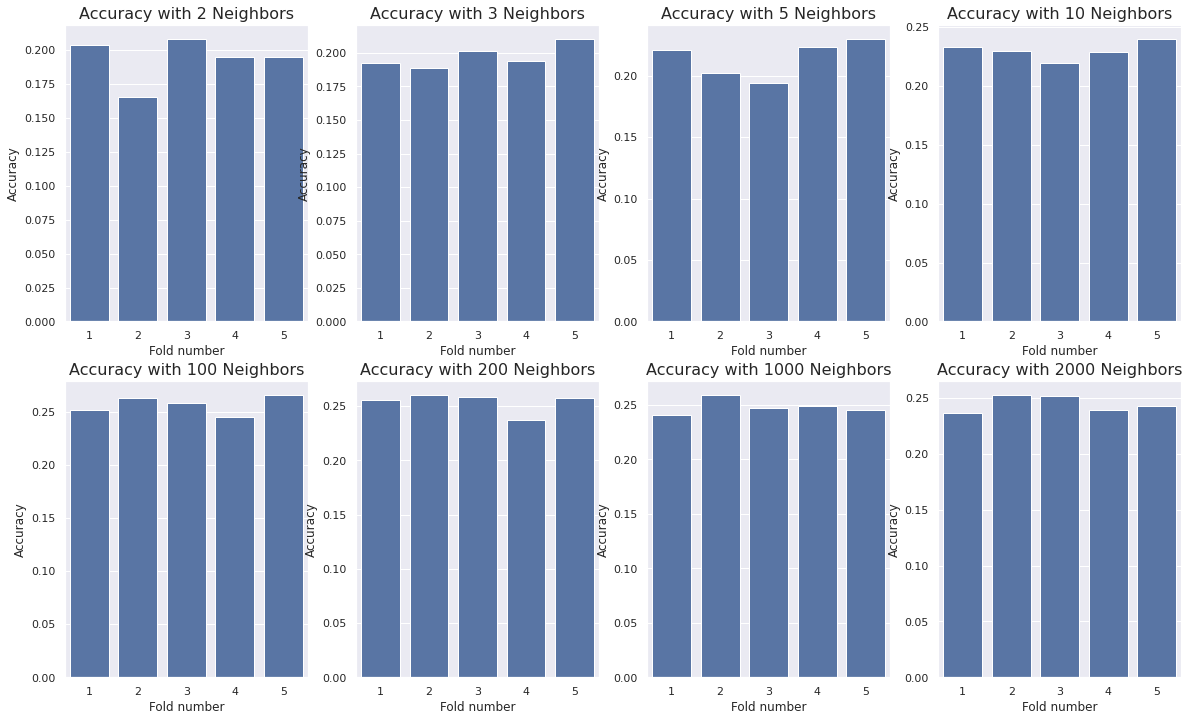

Text(0.5, 0, 'Sample')

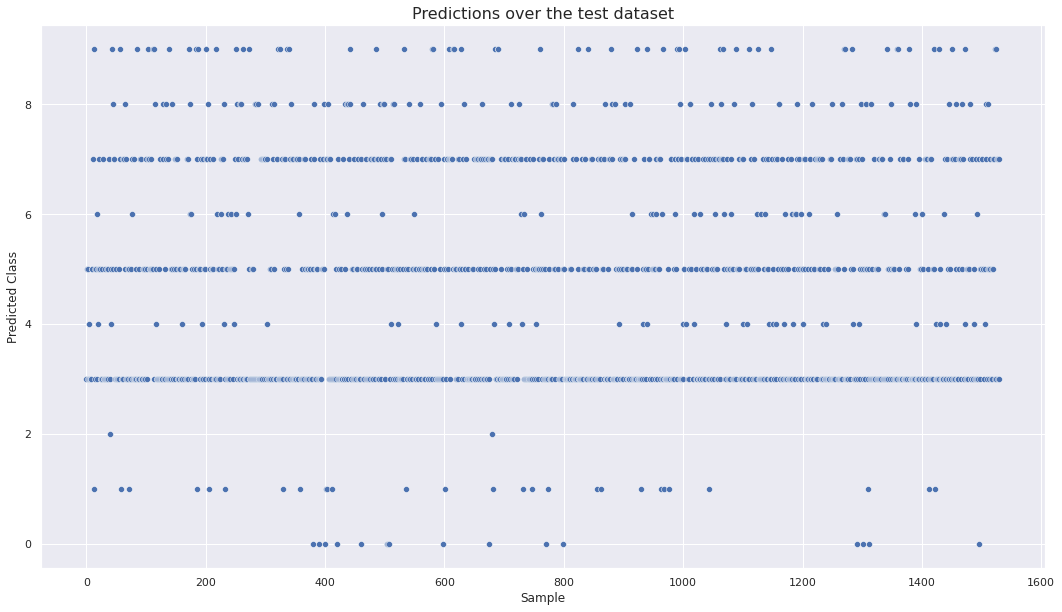

In [5]:
X = pd.get_dummies(df_common_birds.drop("Species ID", axis=1)).values
y = pd.Categorical(df_common_birds["Species ID"]).codes

X, X_test, y, y_test = train_test_split(X, y)
print(f"Selected {y.shape[0]} samples for training and {y_test.shape[0]} for testing.")

fig, ax = plt.subplots(2, 4, figsize=(20, 12))

kfold = StratifiedKFold(5)
for i, K in enumerate([2, 3, 5, 10, 100, 200, 1000, 2000]):
    scores = []
    # Training over the folds
    for train_index, test_index in kfold.split(X, y):
        X_train, X_val = X[train_index], X[test_index]
        y_train, y_val = y[train_index], y[test_index]

        model = KNeighborsClassifier(K)
        model.fit(X_train, y_train)
        scores.append(model.score(X_val, y_val))
    
    # Displaying the results
    print(f"Model with {K} Neighbors, average accuracy = {np.mean(scores)}")
    sns.barplot(x=np.arange(1, 6), y=scores, color='b', ax=ax[i // 4][i % 4])
    ax[i//4][i%4].set(
        title=f"Accuracy with {K} Neighbors",
        ylabel="Accuracy",
        xlabel="Fold number"
    )

plt.show()
    
# Keeping the model with best accuracy
model = KNeighborsClassifier(100)
model.fit(X, y)
model.score(X_test, y_test)

predictions = model.predict(X_test)
sns.scatterplot(x=np.arange(len(predictions)), y=predictions)
plt.title("Predictions over the test dataset")
plt.ylabel("Predicted Class")
plt.xlabel("Sample")

Separed 18192 samples for training and 6065 for testing.
Model with 2 Neighbors, average accuracy = 0.7871041543259366
Model with 3 Neighbors, average accuracy = 0.7585202212727822
Model with 5 Neighbors, average accuracy = 0.7794635145704081
Model with 10 Neighbors, average accuracy = 0.8055738479102376
Model with 100 Neighbors, average accuracy = 0.8101363262596685
Model with 200 Neighbors, average accuracy = 0.8101363262596685
Model with 1000 Neighbors, average accuracy = 0.8101363262596685
Model with 2000 Neighbors, average accuracy = 0.8101363262596685


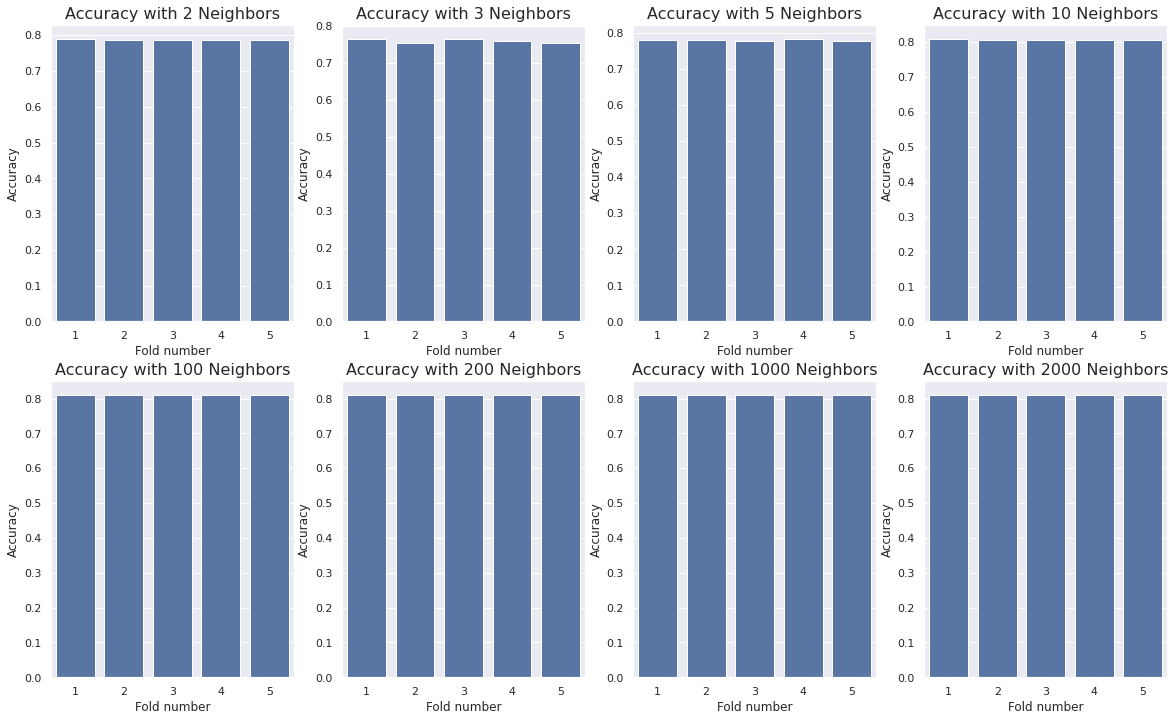

Text(0.5, 0, 'Sample')

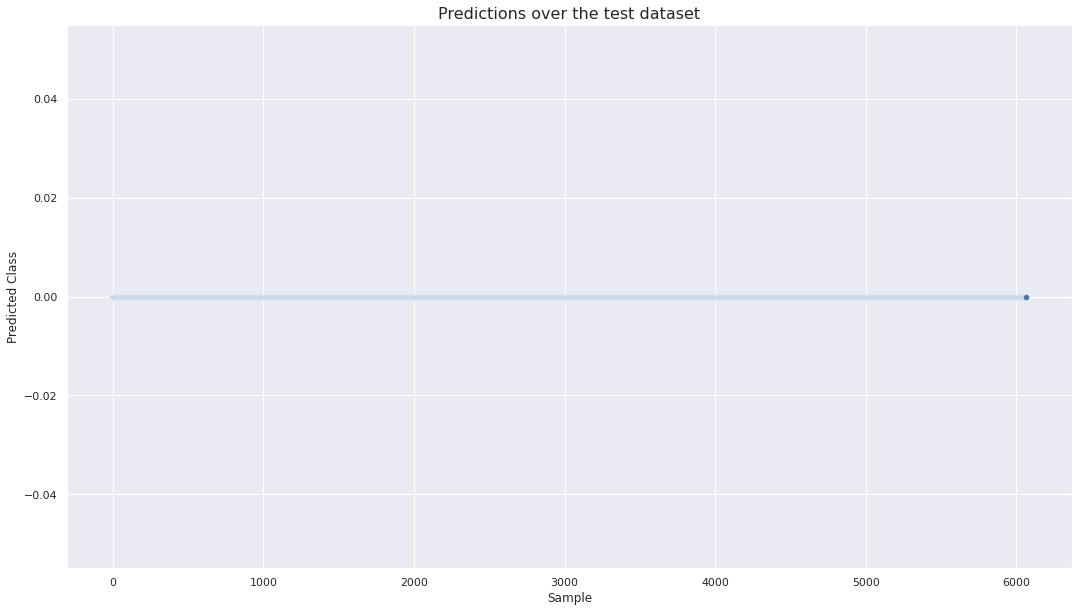

In [6]:
# Droping 'Over 100' due to the lack of samples
df_quantity = df_filtered[df_filtered["Species Quantity"] != "Over 100"]

X = pd.get_dummies(df_quantity.drop("Species Quantity", axis=1)).values
y = pd.Categorical(df_quantity["Species Quantity"]).codes

X, X_test, y, y_test = train_test_split(X, y)
print(f"Separed {y.shape[0]} samples for training and {y_test.shape[0]} for testing.")

fig, ax = plt.subplots(2, 4, figsize=(20, 12))

kfold = StratifiedKFold(5)
for i, K in enumerate([2, 3, 5, 10, 100, 200, 1000, 2000]):
    scores = []
    for train_index, test_index in kfold.split(X, y):
        X_train, X_val = X[train_index], X[test_index]
        y_train, y_val = y[train_index], y[test_index]

        model = KNeighborsClassifier(K)
        model.fit(X_train, y_train)
        scores.append(model.score(X_val, y_val))
        
    print(f"Model with {K} Neighbors, average accuracy = {np.mean(scores)}")
    sns.barplot(x=np.arange(1, 6), y=scores, color='b', ax=ax[i // 4][i % 4])
    ax[i//4][i%4].set(
        title=f"Accuracy with {K} Neighbors",
        ylabel="Accuracy",
        xlabel="Fold number"
    )
    
plt.show()
    
model = KNeighborsClassifier(100)
model.fit(X, y)
model.score(X_test, y_test)

predictions = model.predict(X_test)
sns.scatterplot(x=np.arange(len(predictions)), y=predictions)
plt.title("Predictions over the test dataset")
plt.ylabel("Predicted Class")
plt.xlabel("Sample")

Separed 18199 samples for training and 6067 for testing.
Model with 2 Neighbors, average accuracy = 0.8310896756444984
Model with 3 Neighbors, average accuracy = 0.8730696755841028
Model with 5 Neighbors, average accuracy = 0.8896092846422607
Model with 10 Neighbors, average accuracy = 0.8949942322036304
Model with 100 Neighbors, average accuracy = 0.8953239176322441
Model with 200 Neighbors, average accuracy = 0.8953239176322441
Model with 1000 Neighbors, average accuracy = 0.8953239176322441
Model with 2000 Neighbors, average accuracy = 0.8953239176322441


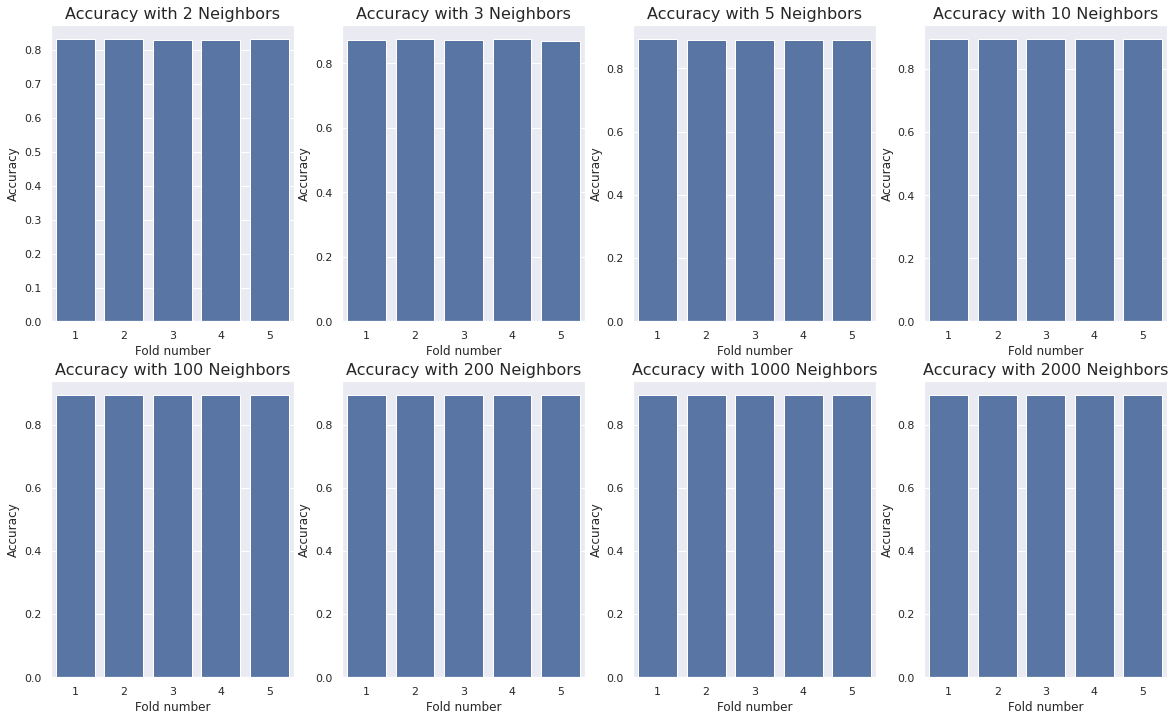

Text(0.5, 0, 'Sample')

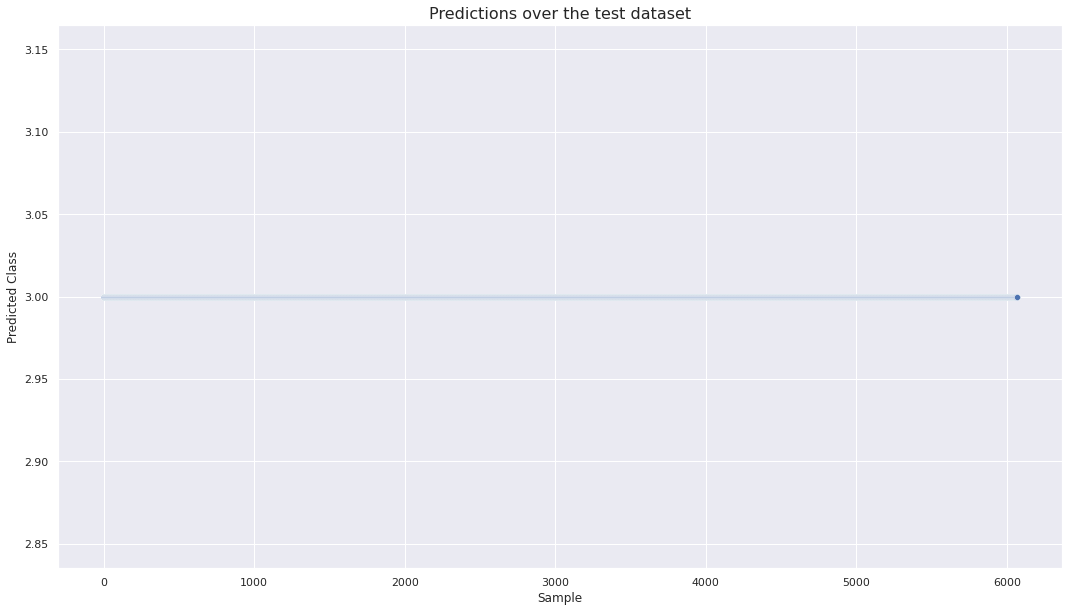

In [7]:
X = pd.get_dummies(df_filtered.drop("Flight Impact", axis=1)).values
y = pd.Categorical(df_filtered["Flight Impact"]).codes

X, X_test, y, y_test = train_test_split(X, y)
print(f"Separed {y.shape[0]} samples for training and {y_test.shape[0]} for testing.")

fig, ax = plt.subplots(2, 4, figsize=(20, 12))

kfold = StratifiedKFold(5)
for i, K in enumerate([2, 3, 5, 10, 100, 200, 1000, 2000]):
    scores = []
    for train_index, test_index in kfold.split(X, y):
        X_train, X_val = X[train_index], X[test_index]
        y_train, y_val = y[train_index], y[test_index]

        model = KNeighborsClassifier(K)
        model.fit(X_train, y_train)
        scores.append(model.score(X_val, y_val))
    
    print(f"Model with {K} Neighbors, average accuracy = {np.mean(scores)}")
    sns.barplot(x=np.arange(1, 6), y=scores, color='b', ax=ax[i // 4][i % 4])
    ax[i//4][i%4].set(
        title=f"Accuracy with {K} Neighbors",
        ylabel="Accuracy",
        xlabel="Fold number"
    )
    
plt.show()
model = KNeighborsClassifier(100)
model.fit(X, y)
model.score(X_test, y_test)
predictions = model.predict(X_test)
sns.scatterplot(x=np.arange(len(predictions)), y=predictions)
plt.title("Predictions over the test dataset")
plt.ylabel("Predicted Class")
plt.xlabel("Sample")